Code for Manuel D, Sowers RB. Optimal transport to cold chain in perishable hand-picked agriculture. Natural Resource Modeling. 2017;30:e12124. https://doi.org/10.1111/nrm.12124

Project Director: Richard Sowers r-sowers@illinois.edu <https://publish.illinois.edu/r-sowers/>

Copyright 2018 University of Illinois Board of Trustees. All Rights Reserved. Licensed under the MIT license

In [2]:
import bisect
import numpy
import random
import math
import matplotlib.pyplot as plotter
%matplotlib inline
import sys
from scipy.optimize import basinhopping

In [3]:
class makeFunctions:
	#constructs functions from linear data (see invocation code)

	def _rzero(self,tStart,b,m):
		def ell(t):
			return b+m*(t-tStart)
		return ell

	def _Rzero(self,tStart,b,m,initialValue):
		def f(t):
			out=initialValue+\
				b*(t-tStart)+\
				(1/2)*m*(t-tStart)**2
			return out
		return f

	def _rone(self,tStart,b,m):
		def f(t):
			return t*( b+m*(t-tStart) )
			'''
			t*( b+m*(t-tStart) )
			=(t-tStart+tStart)*( b+m*(t-tStart) )
			=b*tStart+(b+m*tStart)(t-tStart)+m*(t-tStart)**2
			'''
		return f

	def _Rone(self,tStart,b,m,initialValue):
		def f(t):
			# ell(t)=(b-m*time) * t + m*t^2
			out=initialValue+ \
				b*tStart*(t-tStart)+ \
				(1/2)*(b+m*tStart)*(t-tStart)**2+ \
				(1/3)*m*(t-tStart)*(t-tStart)**3
			return out
		return f


	def rone(self,t):
		n=bisect.bisect(self.Times,t)
		return 0 if n==0 else self._knotList[n-1]["rone"](t)

	def Rone(self,t):
		n=bisect.bisect(self.Times,t)
		return 0 if n==0 else self._knotList[n-1]["Rone"](t)


	def rzero(self,t):
		n=bisect.bisect(self.Times,t)
		return 0 if n==0 else self._knotList[n-1]["rzero"](t)

	def Rzero(self,t):
		n=bisect.bisect(self.Times,t)
		return 0 if n==0 else self._knotList[n-1]["Rzero"](t)


	def RzeroInv(self,h):
		'''
		Rzero maps time to harvest(h).  RzeroInv maps h to t
		'''
		h=min(h,self.totalHarvest) #be careful that h is not out of bounds
		def recur(aa,bb):
			stopFlag=False
			stopFlag=stopFlag or ((bb-aa)<self._tolerance*(self.endTime-self.startTime))
			stopFlag=stopFlag or ((self.Rzero(bb)-self.Rzero(aa))<self._tolerance*self.totalHarvest)
			if stopFlag:
				return aa
			mid=(aa+bb)/2
			#print("mid=",mid)
			return recur(mid,bb) if (h>self.Rzero(mid)) else recur(aa,mid)
		return recur(0,self.totalHarvest)

	def __init__(self,knotList):
		self._tolerance=0.001
		def getTime(knot):
			return knot["t"]

		self._knotList=sorted(knotList,key=getTime)
		self.Times=[getTime(knot) for knot in self._knotList]
		self.startTime=self.Times[0]
		self.endTime=self.Times[-1]


		for n, k in enumerate(self._knotList):
			time=k["t"]
			b=k["b"] if "b" in k else 0
			m=k["m"] if "m" in k else 0
			k["rzero"]=self._rzero(time,b,m)
			k["rone"]=self._rone(time,b,m)

			RPrior=0 if n==0 else self._knotList[n-1]["Rzero"](time)
			RtPrior=0 if n==0 else self._knotList[n-1]["Rone"](time)
			k["Rzero"]=self._Rzero(time,b,m,RPrior)
			k["Rone"]=self._Rone(time,b,m,RtPrior)


		self.limits=[]
		for n,t in enumerate(self.Times):
			temp={"time":t}
			if (n>=1):
				temp["left"]=self._knotList[n-1]["rzero"](t)
			if (n<len(self.Times)-1):
				temp["right"]=self._knotList[n]["rzero"](t)
			self.limits.append(temp)
		#print("self.limits: ",self.limits)
		self.totalHarvest=self.Rzero(self.endTime)
		negativeFlag=any([((("left" in limit) and (limit["left"]<0)) or \
			(("right" in limit) and (limit["right"]<0))) for limit in self.limits])
		if (negativeFlag):
			print("rzero is negative")

In [4]:
class Optimization:

	def __init__(self,knotList):
		self.Functions=makeFunctions(knotList)
		self.Times=self.Functions.Times


		self.Rzero=self.Functions.Rzero
		self.Rone=self.Functions.Rone
		self.RzeroInv=self.Functions.RzeroInv
		self.totalHarvest=self.Functions.totalHarvest
		print("total Harvest: ",self.totalHarvest)
		self.minTime=self.Functions.startTime
		self.maxTime=self.Functions.endTime
		self.limits=self.Functions.limits
		self.optimalTimes=None
		random.seed(0)
		self.C=None
		self.ctr=1

	def basin_accept_test(self,**kwargs):
		self.ctr+=1
		x=numpy.array(kwargs["x_new"])
		Flag=(min(x)>=0) and (sum(x)<=self.totalHarvest)
		if self.C is not None:
			Flag=Flag and (max(x)<=self.C)
		return bool(Flag)

	def basin_callback(self,x,f,accept):
		if accept:
			#print("(",self.ctr,",",-f,")",end=" ",flush=True)
			print(self.ctr,end=" ",flush=True)

	def basinhopping(self,init=None,niter=100):
		init=numpy.init(x) if init is not None else self.equalLoads()["loads"]
		res=basinhopping(lambda x: -self.Value(x),x0=init,niter=niter,accept_test=self.basin_accept_test,callback=self.basin_callback,disp=False)
		print("\n")
		print(res)
		optimalLoadsValue=-res.fun
		loads=res.x
		self.optimalTimes=[self.RzeroInv(cL) for cL in numpy.cumsum(loads)]
		return {"loads":res.x,"times":self.optimalTimes}

	def setConstants(self,k,C,NTrucks=None,V=1):
		self.V=V
		self.k=k
		self.C=C
		self.trucksNeeded=math.ceil(self.totalHarvest/self.C)
		print("need at least "+str(self.trucksNeeded)+" trucks")
		self.NTrucks=NTrucks if NTrucks is not None else self.trucksNeeded
		print("scheduling "+str(self.NTrucks)+" trucks")
		self.optimalTimes=None

	def Value(self,loads):
		loads=numpy.array(loads)
		times=[self.minTime]+[self.RzeroInv(load) for load in numpy.cumsum(loads)]
		intervals=[(max(times[n-1],times[n]-1/self.k),times[n]) for n in range(1,len(times))]
		out=[(1-self.k*end)*(self.Rzero(end)-self.Rzero(begin))+self.k*(self.Rone(end)-self.Rone(begin)) for (begin,end) in intervals]
		return numpy.sum(out)

	def equalLoads(self):
		averageLoad=min(self.totalHarvest/self.NTrucks,self.C)
		loads=[averageLoad for n in range(self.NTrucks)]
		times=[self.RzeroInv(cL) for cL in numpy.cumsum(loads)]
		return {"loads":loads,"times":times}



	def fullTrucks(self):
		temp=[self.C for n in range(self.NTrucks)]
		cumLoads=[min(cumLoad,self.totalHarvest) for cumLoad in numpy.cumsum(temp)]
		cumLoads=numpy.array([0]+cumLoads)
		times=[self.RzeroInv(cL) for cL in cumLoads]
		loads=cumLoads[1:]-cumLoads[:-1]
		return {"loads":loads,"times":times}

	def plot(self):
		vertices=[]
		for limit in self.limits:
			if "left" in limit:
				vertices.append((limit["time"],limit["left"]))
			if "right" in limit:
				vertices.append((limit["time"],limit["right"]))
		vertices=numpy.array(vertices)
		plotter.plot(vertices[:,0],vertices[:,1],linewidth=5,label='rate')

		if self.optimalTimes is not None:
			for n,t in enumerate(self.optimalTimes):
				plotter.axvline(x=t,linewidth=5,color='red',linestyle='dashed',label='optimal' if n==0 else None)

		for n,t in enumerate(self.equalLoads()["times"]):
				plotter.axvline(x=t,linewidth=5,color='green',linestyle='dashdot',label='equal loads' if n==0 else None)

		plotter.ylim((0,max(vertices[:,1])+1))
		plotter.legend(loc='upper left')

		plotter.title('Optimal Cooling Schedule')
		plotter.xlabel('time')
		plotter.ylabel('rate')
		plotter.show()

First case

In [5]:
knots=[\
    {"t":0,"b":1,"m":2},\
    {"t":1,"b":3},\
    {"t":3,"b":3,"m":-1},\
    {"t":4},\
    {"t":4.5,"b":2},\
    {"t":6,"b":2,"m":-1},\
    {"t":7}\
    ]
k=.2
C=3
N=8 #5 needed

total Harvest:  15.0
need at least 5 trucks
scheduling 8 trucks
4 5 8 13 16 17 20 21 23 25 27 28 29 30 34 35 37 41 46 47 48 49 53 54 55 56 57 60 61 62 64 66 68 71 72 73 75 86 88 89 90 92 93 94 95 102 103 108 111 114 119 120 121 122 127 130 131 145 147 150 151 154 156 158 166 172 173 176 178 179 182 184 185 186 188 190 191 193 195 198 213 215 218 221 223 229 230 231 232 234 235 236 238 239 240 241 242 243 245 246 248 250 253 259 261 262 263 264 266 267 268 269 270 271 272 273 275 276 277 278 280 282 284 285 289 290 291 292 296 298 299 300 301 302 303 307 309 312 313 314 315 316 317 318 322 323 324 325 328 329 330 331 332 333 334 335 336 340 341 343 344 345 347 348 349 350 351 352 354 355 356 357 358 359 360 361 362 363 364 365 366 367 368 371 373 374 375 376 377 378 379 380 381 382 383 384 385 386 387 388 389 390 391 392 393 395 396 397 399 400 401 402 403 404 405 406 410 412 413 414 415 416 418 419 421 425 426 427 428 430 432 434 435 436 437 438 439 440 441 443 444 445 446 447 448 449 

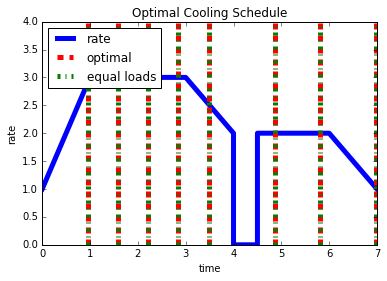

In [6]:
myF=makeFunctions(knots)
myO=Optimization(knots)
myO.setConstants(k,C,N)
fullTrucks=myO.fullTrucks()
fullTrucksValue=myO.Value(fullTrucks["loads"])
equalLoads=myO.equalLoads()
equalLoadsValue=myO.Value(equalLoads["loads"])
optimalLoads=myO.basinhopping(niter=1000)
optimalLoadsValue=myO.Value(optimalLoads["loads"])

print("total harvest:",myF.totalHarvest)
print("start time:",myF.startTime)
print("end time:",myF.endTime)
print("Value for full Trucks: ",fullTrucksValue)
print("Value for equally loaded trucks: ",equalLoadsValue)
print("Value for optimally loaded trucks: ",myO.Value(optimalLoads["loads"]))
equalLoadsImprovement=(optimalLoadsValue-equalLoadsValue)/equalLoadsValue*100
fullTrucksImprovement=(optimalLoadsValue-fullTrucksValue)/fullTrucksValue*100
print("equal Loads improvement: ",round(equalLoadsImprovement,2),"%")
print("full trucks improvement: ",round(fullTrucksImprovement,2),"%")
myO.plot()

second case

In [7]:
knots=[\
    {"t":0,"b":1,"m":2},\
    {"t":1,"b":3},\
    {"t":3,"b":3,"m":-1},\
    {"t":4},\
    {"t":4.5,"b":2},\
    {"t":6,"b":2,"m":-1},\
    {"t":7}\
    ]
k=.8
C=3
N=8 #5 needed

total Harvest:  15.0
need at least 5 trucks
scheduling 8 trucks
3 8 9 12 15 16 17 19 20 21 22 27 28 29 30 34 35 36 38 39 41 43 49 53 54 55 56 58 59 60 61 62 63 64 65 66 67 69 70 72 76 77 78 79 80 81 82 83 84 88 89 90 92 93 94 95 96 97 99 101 104 105 108 109 111 112 113 117 118 119 120 123 125 126 127 130 131 132 134 135 136 137 138 147 148 155 158 162 164 170 174 178 179 184 186 191 192 195 196 197 204 205 207 208 213 215 217 218 219 221 222 225 229 230 231 232 233 235 236 245 247 249 250 252 253 254 255 257 258 259 260 263 264 267 268 269 270 271 272 273 276 277 278 282 287 292 294 295 297 299 300 301 302 303 305 306 308 310 312 315 316 317 321 323 324 325 331 333 336 338 339 342 343 345 346 351 352 353 354 357 360 361 362 363 364 365 366 367 368 369 370 371 372 374 375 376 377 380 382 383 385 388 389 390 391 393 395 398 399 400 413 414 418 420 421 422 423 424 425 426 427 429 430 432 433 434 435 436 437 440 442 444 445 446 448 449 450 451 452 455 456 457 458 460 467 471 479 480 481 48

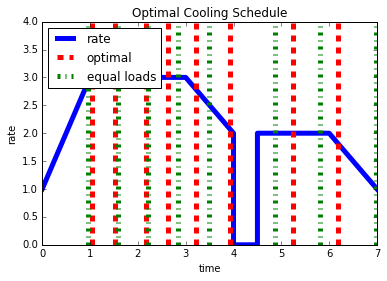

In [8]:
myF=makeFunctions(knots)
myO=Optimization(knots)
myO.setConstants(k,C,N)
fullTrucks=myO.fullTrucks()
fullTrucksValue=myO.Value(fullTrucks["loads"])
equalLoads=myO.equalLoads()
equalLoadsValue=myO.Value(equalLoads["loads"])
optimalLoads=myO.basinhopping(niter=1000)
optimalLoadsValue=myO.Value(optimalLoads["loads"])

print("total harvest:",myF.totalHarvest)
print("start time:",myF.startTime)
print("end time:",myF.endTime)
print("Value for full Trucks: ",fullTrucksValue)
print("Value for equally loaded trucks: ",equalLoadsValue)
print("Value for optimally loaded trucks: ",myO.Value(optimalLoads["loads"]))
equalLoadsImprovement=(optimalLoadsValue-equalLoadsValue)/equalLoadsValue*100
fullTrucksImprovement=(optimalLoadsValue-fullTrucksValue)/fullTrucksValue*100
print("equal Loads improvement: ",round(equalLoadsImprovement,2),"%")
print("full trucks improvement: ",round(fullTrucksImprovement,2),"%")
myO.plot()

third case

In [9]:
knots=[\
    {"t":0,"b":1,"m":2},\
    {"t":1,"b":3},\
    {"t":3,"b":3,"m":-1},\
    {"t":4},\
    {"t":4.5,"b":2},\
    {"t":6,"b":2,"m":-1},\
    {"t":7}\
    ]
k=6
C=3
N=8 #5 needed

total Harvest:  15.0
need at least 5 trucks
scheduling 8 trucks
4 5 6 7 11 12 19 20 21 22 25 26 27 29 32 33 50 56 57 58 59 60 61 62 64 65 69 70 71 72 73 75 76 77 78 79 80 81 84 86 87 88 89 91 92 93 94 95 96 97 99 101 103 104 105 106 115 116 117 118 119 120 123 125 127 128 129 130 131 132 137 138 140 142 143 144 147 148 151 155 161 171 180 183 188 190 197 198 200 201 202 206 208 209 210 211 212 215 218 220 222 223 224 225 226 227 230 232 233 234 236 238 239 244 246 255 258 259 260 261 262 263 264 265 266 267 270 271 272 273 274 275 276 277 279 280 281 282 283 284 285 287 289 290 298 299 300 301 302 303 305 306 309 310 311 312 313 314 315 316 319 320 321 322 323 324 325 326 327 328 329 330 332 335 337 338 339 340 341 342 343 344 345 347 352 353 354 355 356 357 358 360 361 362 364 366 367 369 370 371 372 374 377 378 379 380 381 382 383 389 390 391 392 393 394 395 396 397 399 400 401 402 403 404 405 406 407 408 409 411 412 413 415 418 419 421 422 425 429 430 432 435 437 445 446 447 448 453

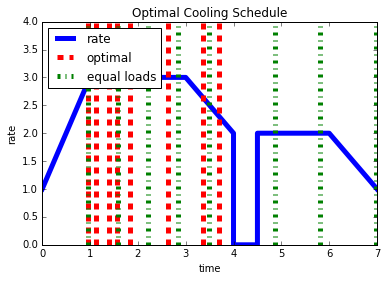

In [10]:
myF=makeFunctions(knots)
myO=Optimization(knots)
myO.setConstants(k,C,N)
fullTrucks=myO.fullTrucks()
fullTrucksValue=myO.Value(fullTrucks["loads"])
equalLoads=myO.equalLoads()
equalLoadsValue=myO.Value(equalLoads["loads"])
optimalLoads=myO.basinhopping(niter=1000)
optimalLoadsValue=myO.Value(optimalLoads["loads"])

print("total harvest:",myF.totalHarvest)
print("start time:",myF.startTime)
print("end time:",myF.endTime)
print("Value for full Trucks: ",fullTrucksValue)
print("Value for equally loaded trucks: ",equalLoadsValue)
print("Value for optimally loaded trucks: ",myO.Value(optimalLoads["loads"]))
equalLoadsImprovement=(optimalLoadsValue-equalLoadsValue)/equalLoadsValue*100
fullTrucksImprovement=(optimalLoadsValue-fullTrucksValue)/fullTrucksValue*100
print("equal Loads improvement: ",round(equalLoadsImprovement,2),"%")
print("full trucks improvement: ",round(fullTrucksImprovement,2),"%")
myO.plot()

third case

In [11]:
knots=[\
    {"t":0,"b":1,"m":2},\
    {"t":1,"b":10},\
    {"t":2,"b":10,"m":-5.5},\
    #{"t":3,"b":3,"m":-1},\
    {"t":4},\
    {"t":4.5,"b":8,"m":-4},\
    {"t":6,"b":2,"m":-1},\
    {"t":7}\
    ]
k=5
C=3
N=13 #9 needed

rzero is negative
rzero is negative
total Harvest:  30.0
need at least 10 trucks
scheduling 13 trucks
6 7 8 10 11 15 20 23 24 37 41 43 50 53 54 64 67 72 77 82 88 90 96 103 110 114 118 123 124 138 139 140 143 145 147 148 155 156 157 174 176 178 180 181 190 194 196 197 202 206 208 210 211 213 219 221 228 230 231 232 233 236 239 240 244 246 247 250 251 252 257 263 265 266 267 269 270 272 273 274 275 281 283 285 293 300 307 312 313 316 320 321 323 324 328 334 335 337 340 342 345 346 354 355 357 358 360 361 362 364 366 367 369 374 377 378 379 384 386 387 388 389 391 393 395 398 400 402 404 406 409 411 412 413 414 415 420 422 424 426 428 430 436 439 440 441 442 443 444 445 448 449 454 455 457 458 459 460 462 466 467 469 470 472 473 475 477 478 479 481 482 491 493 494 496 499 501 502 504 506 507 510 516 517 519 520 521 522 523 524 527 528 530 531 535 536 537 538 542 544 545 547 548 549 550 552 553 557 558 559 560 561 564 565 567 572 573 575 577 578 579 581 586 590 594 602 604 605 606 607 608 

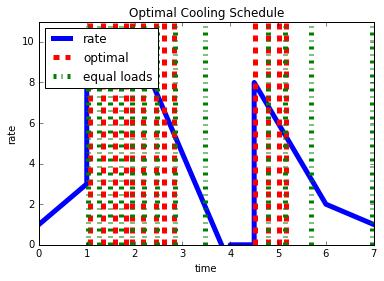

In [12]:
myF=makeFunctions(knots)
myO=Optimization(knots)
myO.setConstants(k,C,N)
fullTrucks=myO.fullTrucks()
fullTrucksValue=myO.Value(fullTrucks["loads"])
equalLoads=myO.equalLoads()
equalLoadsValue=myO.Value(equalLoads["loads"])
optimalLoads=myO.basinhopping(niter=1000)
optimalLoadsValue=myO.Value(optimalLoads["loads"])

print("total harvest:",myF.totalHarvest)
print("start time:",myF.startTime)
print("end time:",myF.endTime)
print("Value for full Trucks: ",fullTrucksValue)
print("Value for equally loaded trucks: ",equalLoadsValue)
print("Value for optimally loaded trucks: ",myO.Value(optimalLoads["loads"]))
equalLoadsImprovement=(optimalLoadsValue-equalLoadsValue)/equalLoadsValue*100
fullTrucksImprovement=(optimalLoadsValue-fullTrucksValue)/fullTrucksValue*100
print("equal Loads improvement: ",round(equalLoadsImprovement,2),"%")
print("full trucks improvement: ",round(fullTrucksImprovement,2),"%")
myO.plot()

fifth case

In [13]:
knots=[\
    {"t":0,"b":1,"m":4},\
    {"t":1,"b":3},\
    {"t":2,"b":10,"m":-6},\
    {"t":3,"b":3,"m":-2},\
    {"t":4},\
    {"t":4.5,"b":5,"m":2},\
    {"t":6,"b":2,"m":-1},\
    {"t":7}\
    ]
k=1#was .3
C=3
N=11 #need 9

total Harvest:  26.25
need at least 9 trucks
scheduling 11 trucks
6 7 10 15 17 50 52 60 61 66 70 73 76 79 85 87 94 105 106 107 108 110 112 114 117 118 121 125 126 130 144 160 161 167 168 169 171 175 178 189 192 194 197 199 202 206 207 208 209 214 220 228 241 251 254 255 256 257 258 259 261 263 269 270 271 272 274 275 276 277 278 279 280 281 283 284 286 290 291 293 295 296 297 299 300 301 308 311 320 321 322 323 328 334 338 342 343 346 348 349 352 355 356 358 359 360 364 367 375 376 379 384 393 402 403 404 405 408 409 410 412 413 415 416 418 419 421 423 426 427 428 429 432 436 440 441 442 443 444 446 447 448 450 452 455 460 462 463 466 473 474 475 476 477 479 482 483 484 490 491 494 495 496 498 499 504 505 506 507 508 510 511 513 522 524 527 530 532 533 534 537 539 540 542 543 544 545 546 547 548 551 552 553 555 556 557 558 559 560 561 562 564 565 566 567 568 569 570 571 572 573 574 575 576 577 578 579 580 581 582 584 586 590 591 592 593 594 595 596 597 598 600 601 602 603 604 605 606 6

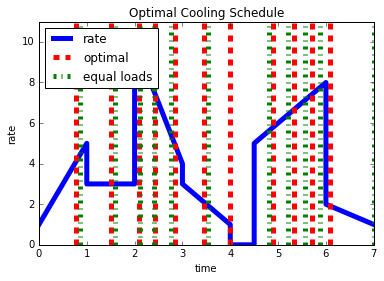

In [14]:
myF=makeFunctions(knots)
myO=Optimization(knots)
myO.setConstants(k,C,N)
fullTrucks=myO.fullTrucks()
fullTrucksValue=myO.Value(fullTrucks["loads"])
equalLoads=myO.equalLoads()
equalLoadsValue=myO.Value(equalLoads["loads"])
optimalLoads=myO.basinhopping(niter=1000)
optimalLoadsValue=myO.Value(optimalLoads["loads"])

print("total harvest:",myF.totalHarvest)
print("start time:",myF.startTime)
print("end time:",myF.endTime)
print("Value for full Trucks: ",fullTrucksValue)
print("Value for equally loaded trucks: ",equalLoadsValue)
print("Value for optimally loaded trucks: ",myO.Value(optimalLoads["loads"]))
equalLoadsImprovement=(optimalLoadsValue-equalLoadsValue)/equalLoadsValue*100
fullTrucksImprovement=(optimalLoadsValue-fullTrucksValue)/fullTrucksValue*100
print("equal Loads improvement: ",round(equalLoadsImprovement,2),"%")
print("full trucks improvement: ",round(fullTrucksImprovement,2),"%")
myO.plot()